In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy

from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

In [1]:
#!/usr/bin/env python

######################
"""
1. demonstration of Array-derived-rotation
2. Data source from IRIS PFO array (http://www.fdsn.org/networks/detail/PY/)
3. more detail refer to https://doi.org/10.1785/0220160216
4. relationship between rotation and gradient

rotation_X = -u_nz
rotation_Y =  u_ez
rotation_Z = 0.5*(u_ne-u_en)
"""
######################


def __compute_adr_pfo(tbeg, tend, submask=None):

    import os
    import numpy as np
    import timeit

    from obspy import UTCDateTime, Stream
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    ## _____________________________________________________

    ## start timer for runtime
    start_timer = timeit.default_timer()


    ## _____________________________________________________

    ## generate configuration object
    config = {}

    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    ## select the fdsn client for the stations
    config['fdsn_client'] = Client('IRIS')


    ## select stations to consider:
    ## all: [0,1,2,3,4,5,6,7,8,9,10,11,12] | optimal: [0,5,8,9,10,11,12] | inner: [0,1,2,3]
    if submask is not None:
        if submask == "inner":
            config['subarray_mask'] = [0,1,2,3,4]
            config['freq1'] = 0.16  ## 0.00238*3700/100
            config['freq2'] = 16.5 ## 0.25*3700/100
        elif submask == "optimal":
            config['subarray_mask'] = [0,1,6,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
        elif submask == "all":
            config['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
    else:
        config['subarray_mask'] = [0,1,2,3,4]


    ## decide if information is printed while running the code
    config['print_details'] = False

    ## _____________________
    ## PFO array information

    if config['tbeg'] > UTCDateTime("2023-04-01"):
        config['reference_station'] = 'PY.PFOIX' ## 'BPH01'  ## reference station

        config['array_stations'] = ['PY.PFOIX','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']
    else:
        config['reference_station'] = 'II.PFO' ## 'BPH01'  ## reference station

        config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


    config['misorientations'] =  [0, 0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375
                                  ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]


    config['subarray_misorientation'] = [config['misorientations'][i] for i in config['subarray_mask']]
    config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]

    ## ______________________________
    ## parameter for array-derivation

    #config['prefilt'] = (0.001, 0.01, 5, 10)
    config['apply_bandpass'] = True


    # adr parameters
    config['vp'] = 6200 #6264. #1700
    config['vs'] = 3700 #3751. #1000
    config['sigmau'] = 1e-4 # 0.0001


    ## _____________________________________________________


    def __get_inventory_and_distances(config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            inven = config['fdsn_client'].get_stations(network=net,
                                                       station=sta,
                                                       channel=cha,
                                                       starttime=config['tbeg'],
                                                       endtime=config['tend'],
                                                       level='response'
                                                      )

            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            if i == 0:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            lon, lat = util_geo_km(o_lon,o_lat,l_lon,l_lat)
            coo.append([lon*1000,lat*1000,height-o_height])  ## convert unit from km to m

        return inven, np.array(coo)


    def __check_samples_in_stream(st, config):

        for tr in st:
            if tr.stats.npts != config['samples']:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {config['samples']})")
                st.remove(tr)

        return st


    def __get_data(config):


        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


            ## querry inventory data
            try:
                inventory = config['fdsn_client'].get_stations(
                                                                 network=net,
                                                                 station=sta,
                                                                 channel=cha,
                                                                 starttime=config['tbeg']-20,
                                                                 endtime=config['tend']+20,
                                                                )
            except:
                print(" -> Failed to load inventory!")
                inventory = None

            ## try to get waveform data
            try:
                stats = config['fdsn_client'].get_waveforms(
                                                            network=net,
                                                            station=sta,
                                                            location=loc,
                                                            channel=cha,
                                                            starttime=config['tbeg']-20,
                                                            endtime=config['tend']+20,
                                                            attach_response=True,
                                                            )
            except Exception as E:
                print(E) if config['print_details'] else None
                print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
                continue



            ## merge if masked
            if len(stats) > 3:
                print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
                stats.merge(method=1, fill_value="interpolate")


            ## sorting
            stats.sort().reverse()


            ## remove response [VEL -> rad/s | DISP -> rad]
            stats.remove_response(output="VEL")


            #correct mis-alignment
            stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
                                                                     stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
                                                                     stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


            ## trim to interval
#             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

            ## rotate to ZNE
            try:
                if "BPH" in sta:
                    stats.rotate(method="->ZNE", inventory=inventory)
            except:
                print(" -> failed to rotate to ZNE")
                continue

            ## rename channels
            if net == "II" and sta == "PFO":
                for tr in stats:
                    if tr.stats.channel[-1] == "1":
                        tr.stats.channel = str(tr.stats.channel).replace("1","E")
                    if tr.stats.channel[-1] == "2":
                        tr.stats.channel = str(tr.stats.channel).replace("2","N")

            if config['reference_station'] == "PY.PFOIX":
                stats = stats.resample(40)
                stats = stats.trim(config['tbeg']-20, config['tend']+20)


            if station == config['reference_station']:
                ref_station = stats.copy()

            st += stats


        print(st.__str__(extended=True)) if config['print_details'] else None

        ## update subarray stations if data could not be requested for all stations
        if len(st) < 3*len(config['subarray_stations']):
            config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
            config['subarray_stations'] = list(set(config['subarray_stations']))


        print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config


    def __compute_ADR(tse, tsn, tsz, config, ref_station):

        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        print(' ADR is executing...') if config['print_details'] else None

        try:
            result = AA.array_rotation_strain(np.arange(len(config['subarray_stations'])),
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['coo'],
                                              config['sigmau'],
                                          )
        except Exception as E:
            print(E)
            print("\n -> failed to compute ADR...")
            return None

        ## create rotation stream and add data
        rotsa = ref_station.copy()

        rotsa[0].data = result['ts_w3']
        rotsa[1].data = result['ts_w2']
        rotsa[2].data = result['ts_w1']

        rotsa[0].stats.channel='BJZ'
        rotsa[1].stats.channel='BJN'
        rotsa[2].stats.channel='BJE'

        rotsa[0].stats.station='RPFO'
        rotsa[1].stats.station='RPFO'
        rotsa[2].stats.station='RPFO'

        rotsa = rotsa.detrend('simple')


    #     gradient_ZNE = result['ts_ptilde'] #u1,1 u1,2 u1,3 u2,1 u2,2 u2,3
    #     u_ee=gradient_ZNE[:,0]
    #     u_en=gradient_ZNE[:,1]
    #     u_ez=gradient_ZNE[:,2]
    #     u_ne=gradient_ZNE[:,3]
    #     u_nn=gradient_ZNE[:,4]
    #     u_nz=gradient_ZNE[:,5]


        #(Gradient trace)
        #      Gradient = o_stats.copy()        #information of the central station
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient[0].data = u_ee
        #      Gradient[1].data = u_en
        #      Gradient[2].data = u_ez
        #      Gradient[3].data = u_ne
        #      Gradient[4].data = u_nn
        #      Gradient[5].data = u_nz
        #      Gradient[0].stats.channel='uee'
        #      Gradient[1].stats.channel='uen'
        #      Gradient[2].stats.channel='uez'
        #      Gradient[3].stats.channel='une'
        #      Gradient[4].stats.channel='unn'
        #      Gradient[5].stats.channel='unz'


        return rotsa


    ## MAIN ##

    ## launch a times
    start_timer1 = timeit.default_timer()

    ## request data for pfo array
    st, ref_station, config = __get_data(config)

    ## check if enough stations for ADR are available otherwise continue
    if len(st) < 9:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    ## get inventory and coordinates/distances
    inv, config['coo'] = __get_inventory_and_distances(config)

    ## processing
#    st.trim(config['tbeg'], config['tend'])
    st.detrend("demean")

    if config['apply_bandpass']:
        st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
        print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")


#     print(st.__str__(extended=True))

    ## prepare data arrays
    tsz, tsn, tse = [],[],[]
    for tr in st:
        try:
            if "Z" in tr.stats.channel:
                tsz.append(tr.data)
            elif "N" in tr.stats.channel:
                tsn.append(tr.data)
            elif "E" in tr.stats.channel:
                tse.append(tr.data)
        except:
            print(" -> stream data could not be appended!")

    ## compute array derived rotation (ADR)
    rot = __compute_ADR(tse, tsn, tsz, config, ref_station)


    ## trim to requested interval
#     rot.trim(config['tbeg'], config['tend'], nearest_sample=False)
    rot = rot.trim(config['tbeg'], config['tend'])


    ## stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60,2)} minutes")


    return rot


## End of File

In [2]:
def __get_data(config):


    config['subarray'] = []

    st = Stream()

    for k, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        if net == "II" and sta == "PFO":
            loc, cha = "10", "BH*"
        elif net == "PY" and sta == "PFOIX":
            loc, cha = "", "HH*"
        else:
            loc, cha = "", "BH*"

        print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


        ## querry inventory data
        try:
            inventory = config['fdsn_client'].get_stations(
                                                             network=net,
                                                             station=sta,
                                                             channel=cha,
                                                             starttime=config['tbeg']-20,
                                                             endtime=config['tend']+20,
                                                            )
        except:
            print(" -> Failed to load inventory!")
            inventory = None

        ## try to get waveform data
        try:
            stats = config['fdsn_client'].get_waveforms(
                                                        network=net,
                                                        station=sta,
                                                        location=loc,
                                                        channel=cha,
                                                        starttime=config['tbeg']-20,
                                                        endtime=config['tend']+20,
                                                        attach_response=True,
                                                        )
        except Exception as E:
            print(E) if config['print_details'] else None
            print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
            continue



        ## merge if masked
        if len(stats) > 3:
            print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
            stats.merge(method=1, fill_value="interpolate")


        ## sorting
        stats.sort().reverse()


        ## remove response [VEL -> rad/s | DISP -> rad]
        stats.remove_response(output="VEL")


        #correct mis-alignment
        stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
                                                                 stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
                                                                 stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


        ## trim to interval
#             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

        ## rotate to ZNE
        try:
            if "BPH" in sta:
                stats.rotate(method="->ZNE", inventory=inventory)
        except:
            print(" -> failed to rotate to ZNE")
            continue

        ## rename channels
        if net == "II" and sta == "PFO":
            for tr in stats:
                if tr.stats.channel[-1] == "1":
                    tr.stats.channel = str(tr.stats.channel).replace("1","E")
                if tr.stats.channel[-1] == "2":
                    tr.stats.channel = str(tr.stats.channel).replace("2","N")

        if config['reference_station'] == "PY.PFOIX":
            stats = stats.resample(40)
            stats = stats.trim(config['tbeg']-20, config['tend']+20)


        if station == config['reference_station']:
            ref_station = stats.copy()

        st += stats


    print(st.__str__(extended=True)) if config['print_details'] else None

    ## update subarray stations if data could not be requested for all stations
    if len(st) < 3*len(config['subarray_stations']):
        config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
        config['subarray_stations'] = list(set(config['subarray_stations']))


    print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

    if len(st) == 0:
        return st, Stream(), config
    else:
        return st, ref_station, config

In [41]:
def __add_coordinates(st, config):

    coo = []
    for i, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        if net == "II" and sta == "PFO":
            loc, cha = "10", "BH*"
        elif net == "PY" and sta == "PFOIX":
            loc, cha = "", "HH*"
        else:
            loc, cha = "", "BH*"

        try:
            inven = config['fdsn_client'].get_stations(network=net,
                                                       station=sta,
                                                       channel=cha,
                                                       starttime=config['tbeg'],
                                                       endtime=config['tend'],
                                                       level='response'
                                                      )
        except:
            print(f" -> cannot get inventory for {station}")

        l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
        l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
        height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

        for c in ["Z", "N", "E"]:
            st.select(station=sta, channel=f"*{c}")[0].stats.coordinates = AttribDict({
                                                                                      'latitude': l_lat,
                                                                                      'elevation': height,
                                                                                      'longitude': l_lon
                                                                                       })

    return st

In [8]:
tbeg = "2023-04-01 00:00"
tend = "2023-04-01 00:30"
submask = "inner"

In [58]:
def __compute_beamforming_pfo(tbeg, tend, submask, plot=False):

    import os
    import numpy as np
    import timeit

    from obspy import UTCDateTime, Stream
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    ## _____________________________________________________

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


            ## querry inventory data
            try:
                inventory = config['fdsn_client'].get_stations(
                                                                 network=net,
                                                                 station=sta,
                                                                 channel=cha,
                                                                 starttime=config['tbeg']-20,
                                                                 endtime=config['tend']+20,
                                                                )
            except:
                print(" -> Failed to load inventory!")
                inventory = None

            ## try to get waveform data
            try:
                stats = config['fdsn_client'].get_waveforms(
                                                            network=net,
                                                            station=sta,
                                                            location=loc,
                                                            channel=cha,
                                                            starttime=config['tbeg']-20,
                                                            endtime=config['tend']+20,
                                                            attach_response=True,
                                                            )
            except Exception as E:
                print(E) if config['print_details'] else None
                print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
                continue


            ## merge if masked
            if len(stats) > 3:
                print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
                stats.merge(method=1, fill_value="interpolate")


            ## sorting
            stats.sort().reverse()


            ## remove response [VEL -> rad/s | DISP -> rad]
            stats.remove_response(output="VEL")


            #correct mis-alignment
            stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
                                                                     stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
                                                                     stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


            ## trim to interval
    #             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

            ## rotate to ZNE
            try:
                if "BPH" in sta:
                    stats.rotate(method="->ZNE", inventory=inventory)
            except:
                print(" -> failed to rotate to ZNE")
                continue

            ## rename channels
            if net == "II" and sta == "PFO":
                for tr in stats:
                    if tr.stats.channel[-1] == "1":
                        tr.stats.channel = str(tr.stats.channel).replace("1","E")
                    if tr.stats.channel[-1] == "2":
                        tr.stats.channel = str(tr.stats.channel).replace("2","N")

            if config['reference_station'] == "PY.PFOIX":
                stats = stats.resample(40)
                stats = stats.trim(config['tbeg']-20, config['tend']+20)


            if station == config['reference_station']:
                ref_station = stats.copy()

            st += stats


        print(st.__str__(extended=True)) if config['print_details'] else None

        ## update subarray stations if data could not be requested for all stations
        if len(st) < 3*len(config['subarray_stations']):
            config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
            config['subarray_stations'] = list(set(config['subarray_stations']))


        print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config


    def __add_coordinates(st, config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            try:
                inven = config['fdsn_client'].get_stations(network=net,
                                                           station=sta,
                                                           channel=cha,
                                                           starttime=config['tbeg'],
                                                           endtime=config['tend'],
                                                           level='response'
                                                          )
            except:
                print(f" -> cannot get inventory for {station}")

            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            for c in ["Z", "N", "E"]:
                st.select(station=sta, channel=f"*{c}")[0].stats.coordinates = AttribDict({
                                                                                          'latitude': l_lat,
                                                                                          'elevation': height,
                                                                                          'longitude': l_lon
                                                                                           })

        return st

    ## _____________________________________________________

    ## start timer for runtime
    start_timer = timeit.default_timer()


    ## _____________________________________________________

    ## generate configuration object
    config = {}

    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    ## select the fdsn client for the stations
    config['fdsn_client'] = Client('IRIS')


    ## select stations to consider:
    ## all: [0,1,2,3,4,5,6,7,8,9,10,11,12] | optimal: [0,5,8,9,10,11,12] | inner: [0,1,2,3]
    if submask is not None:
        if submask == "inner":
            config['subarray_mask'] = [0,1,2,3,4]
            config['freq1'] = 0.16  ## 0.00238*3700/100
            config['freq2'] = 16.5 ## 0.25*3700/100
        elif submask == "optimal":
            config['subarray_mask'] = [0,1,6,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
        elif submask == "all":
            config['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
    else:
        config['subarray_mask'] = [0,1,2,3,4]


    ## decide if information is printed while running the code
    config['print_details'] = False

    ## _____________________
    ## PFO array information

    if config['tbeg'] > UTCDateTime("2023-04-01"):
        config['reference_station'] = 'PY.PFOIX' ## 'BPH01'  ## reference station

        config['array_stations'] = ['PY.PFOIX','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']
    else:
        config['reference_station'] = 'II.PFO' ## 'BPH01'  ## reference station

        config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


    config['misorientations'] =  [0, 0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375
                                  ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]


    config['subarray_misorientation'] = [config['misorientations'][i] for i in config['subarray_mask']]
    config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]

    ## ______________________________
    ## parameter for array-derivation
    #config['prefilt'] = (0.001, 0.01, 5, 10)
    config['apply_bandpass'] = True


    ## beamforming parameters
    config['slow_xmin'] = -3.0
    config['slow_xmax'] = 3.0
    config['slow_ymin'] = -3.0
    config['slow_ymax'] = 0.05
    config['slow_steps'] = 0.05

    config['win_length'] = 5.0 # seconds
    config['win_frac'] = 0.2

    config['freq_lower'] = 1.0
    config['freq_upper'] = 20.0
    config['prewhitening'] = 0


    ## loading data
    st, ref_station, config = __get_data(config)

    ## pre-pprocessing data
    st = st.detrend("demean")
    if config['apply_bandpass']:
        st = st.taper(0.1)
        st = st.filter("bandpass", freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)

    ## add coordinates from inventories
    st = __add_coordinates(st, config)

    ## define parameters for beamforming
    kwargs = dict(

        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=config['slow_xmin'], slm_x=config['slow_xmax'],
        sll_y=config['slow_ymin'], slm_y=config['slow_ymax'],
        sl_s=config['slow_steps'],

        # sliding window properties
        win_len=config['win_length'], win_frac=config['win_frac'],

        # frequency properties
        frqlow=config['freq_lower'], frqhigh=config['freq_upper'], prewhiten=config['prewhitening'],

        # restrict output
        semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',

        ## time period
        stime=config['tbeg']+5, etime=config['tend']-5,
    )

    ## perform beamforming
    out = array_processing(st, **kwargs)


    ## stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60,2)} minutes")

    ## ______________________________
    ## Plotting

    if plot:
        labels = ['rel.power', 'abs.power', 'baz', 'slow']

        xlocator = mdates.AutoDateLocator()
        fig = plt.figure(figsize=(11,8))
        for i, lab in enumerate(labels):
            ax = fig.add_subplot(4, 1, i + 1)
            ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
                       edgecolors='none', cmap=obspy_sequential)
            ax.set_ylabel(lab)
            ax.set_xlim(out[0, 0], out[-1, 0])
            ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
            ax.xaxis.set_major_locator(xlocator)
            ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))


        fig.autofmt_xdate()
        fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
        plt.show();

    return out

In [59]:
__compute_beamforming_pfo(tbeg, tend, submask, plot=False)

NameError: name 'start_timer1' is not defined

In [14]:
st, ref_station, config = __get_data(config)

In [42]:
st = __add_coordinates(st, config)

In [48]:
out = array_processing(st, **kwargs)

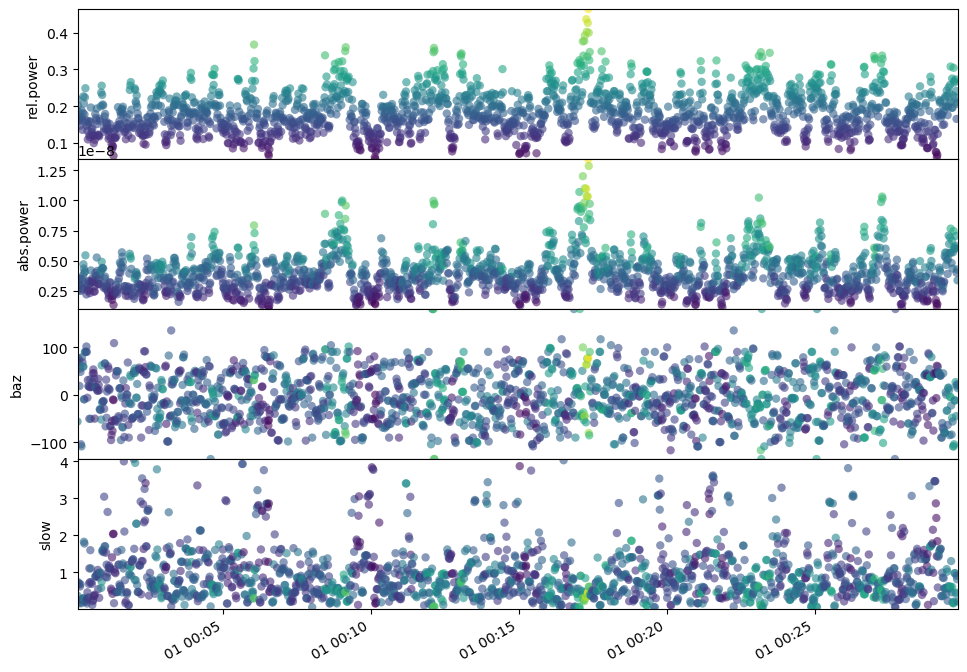

In [50]:
# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure(figsize=(11,8))
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))


fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

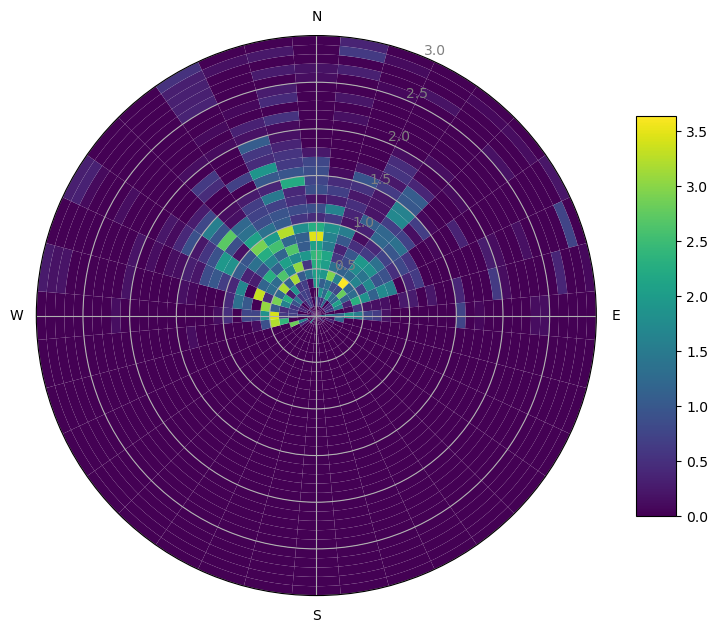

In [51]:
# Plot

cmap = obspy_sequential

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360

# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 36
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)


# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()